In [42]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy, BinaryCrossentropy

In [43]:
dataset, dataset_info = tfds.load("malaria", with_info=True, split= ['train[:80%]', 'train[80%:90%]','train[90%:]'], shuffle_files=True)

In [44]:
train_dataset = dataset[0]
validation_dataset = dataset[1]
test_dataset = dataset[2]
print(dataset_info)

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

In [45]:
len(train_dataset), len(validation_dataset), len(test_dataset)

TRAIN_RATIO= 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1



In [46]:
def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_ds = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
  val_test_ds = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
  val_ds = val_test_ds.take(int(VAL_RATIO * DATASET_SIZE))
  test_ds = val_test_ds.skip(int(VAL_RATIO * DATASET_SIZE))

  return train_ds, val_ds, test_ds


In [47]:
def get_label(sample):
  if sample == 0:
    return 'Parasitized'
  else:
    return 'Uninfected'

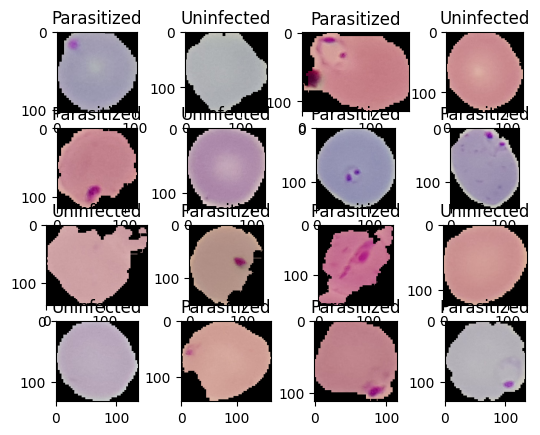

In [48]:
for i, sample in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(sample['image'])
  plt.title(get_label(sample['label'].numpy()))

In [49]:
Im_size = 224
batch_size = 32

In [50]:
def resize(inputs):
  return tf.image.resize(inputs['image'], (Im_size, Im_size))//255., inputs['label']

In [51]:
train_dataset = train_dataset.map(resize).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)

validation_dataset = validation_dataset.map(resize).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)


test_dataset = test_dataset.map(resize).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [52]:
for image, label in train_dataset.take(1):
  print("Image shape: ", image)
  print("Label: ", label)

Image shape:  tf.Tensor(
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
 

In [53]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(Im_size, Im_size, 3),),
    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),

    Flatten(),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),

])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

In [54]:
model.compile(optimizer=Adam(learning_rate = 0.01), loss= BinaryCrossentropy(), metrics=['binary_accuracy'])

In [55]:
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=10)

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/step - binary_accuracy: 0.5027 - loss: 0.6946 - val_binary_accuracy: 0.5112 - val_loss: 2955.0745
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 77s 52ms/step - binary_accuracy: 0.4994 - loss: 0.6937 - val_binary_accuracy: 0.4888 - val_loss: 59571.0938
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - binary_accuracy: 0.5012 - loss: 0.6939 - val_binary_accuracy: 0.5112 - val_loss: 3788090.7500
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - binary_accuracy: 0.4986 - loss: 0.6934 - val_binary_accuracy: 0.5112 - val_loss: 2308680.0000
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 36s 52ms/step - binary_accuracy: 0.5001 - loss: 0.6933 - val_binary_accuracy: 0.5112 - val_loss: 677487.6250
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - binary_accuracy: 0.5014 - loss: 0.6934 - val_binary_accuracy: 0.5112 - val_loss: 5244.0098
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - binary_accuracy: 0.5041 - loss: 0.6934 - val_binary_a

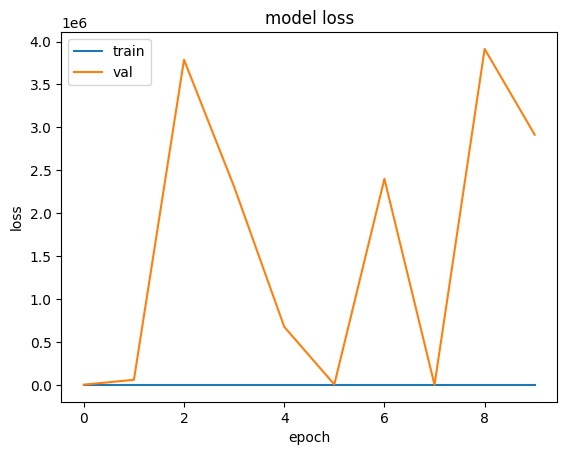

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [39]:
model.evaluate(test_dataset)

87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.5042 - loss: 27.8345


[28.05916404724121, 0.4970972537994385]